## Make patches from labels

Make a set of augmented patches from labels.

As a reminder, in this project

1.  Annotations are the set of 'marked up' image with pixels of objects assigned unique labels.  It may not be desired to use all annotations for training. 
1.  Labels are a set of annotations (marked by bounding boxes) we want to use for training.  
2.  Patches are a set of images and annotated ground truths generated from labels.  They are usually cropped from labels to be all the same size.  They are often augmented.  1 label can be used to generate many patches. 

In the first cell we set up paths to the label images, and get a list of the file names of the labels

In [2]:
from skimage.io import imread
from pathlib import Path
from matplotlib import pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d
import numpy as np
from tnia.deeplearning.dl_helper import quantile_normalization
import json
from tnia.deeplearning.dl_helper import get_label_paths
from tnia.plotting.plt_helper import random_label_cmap
from glob import glob
import os

parent_path = r'D:\images\tnia-python-images\imagesc\2025_03_31_cellpose_not_precise'
parent_path = r'D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense'

parent_path = Path(parent_path)
label_path = Path(parent_path / r'labels')

# open the info file
json_ = json.load(open(label_path / 'info.json'))

# get number of inputs and number of ground truths for this problem
num_inputs = json_['num_inputs']
num_ground_truths = json_['num_truths']
print('num inputs: ', num_inputs)   
print('num ground truth: ', num_ground_truths)

image_label_paths, ground_truths_label_paths = get_label_paths(1, num_ground_truths, label_path)
print('image label paths',image_label_paths)
print("ground_truth_label_paths", ground_truths_label_paths[0])

# get list of tif files in image_label_path
tif_files = glob(str(os.path.join(image_label_paths[0], '*.tif')))
print()
print('The following tif files were found in the image label path: ')
for tif_file in tif_files:
    print("tif_file: ", tif_file)


num inputs:  1
num ground truth:  1
image label paths [WindowsPath('D:/images/tnia-python-images/imagesc/2025_04_07_cellpose_not_precise_dense/labels/input0')]
ground_truth_label_paths D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\labels\ground truth0

The following tif files were found in the image label path: 
tif_file:  D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\labels\input0\Screenshot from 2025-03-31 10-28-06_0.tif


## Display one of the label/ground truth sets

This is done just to check the data looks OK.  Change ```i``` to look at different image/label pairs. 

tiff name is Screenshot from 2025-03-31 10-28-06_0.tif
image shape (395, 456)
image dtype uint8
image max 255
label max 1


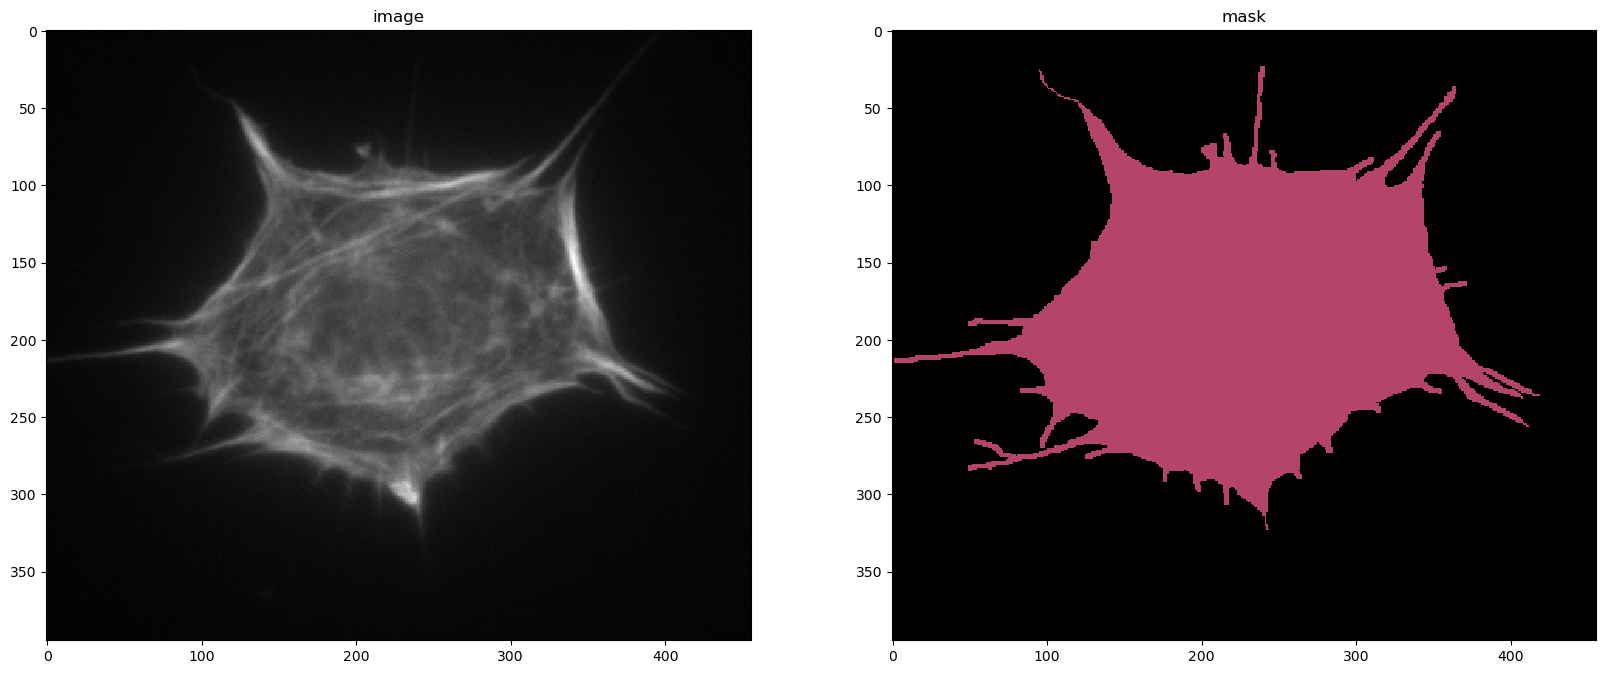

In [3]:
i=0

# get tif name
tif_name = os.path.basename(tif_files[i])
print('tiff name is', tif_name)

image = imread(str(image_label_paths[0]/ (tif_name)))

# read labels (there can be more than one class)
labels = []
for ground_truths_label_path in ground_truths_label_paths:
    label = imread(os.path.join(ground_truths_label_path / (tif_name)))
    labels.append(label)

# show labels image 
images_to_show=[]
titles = []

if image.max() > 255:
    image = image/image.max()

print('image shape', image.shape)
print('image dtype', image.dtype)
print('image max', image.max())
print('label max', label.max())

images_to_show.append(image)
titles.append("image")

for label in labels:
    images_to_show.append(label)
    titles.append("mask")

fig = imshow_multi2d(images_to_show, titles, 1, len(images_to_show), width=20, height=10, colormaps = ['gray', random_label_cmap()])


## Augment and normalize images

Note: Normalization is always tricky.  We want to normalize based on the expected range in real images, which are often larger than training patches.  So here we normalize first, then extract the patches, so that all patches are normalized based on the expected intensity range of full sized images (not intensity range of the patch).

In [12]:
import os
from tnia.deeplearning.augmentation import uber_augmenter
from tnia.deeplearning.dl_helper import generate_next_name
from skimage.io import imsave

i=0

num_patches = 20

for i in range(len(tif_files)):
    # get tif name
    tif_name = os.path.basename(tif_files[i])
    print('tiff name is', tif_name)
    image = imread(str(image_label_paths[0]/ (tif_name)))
    #ind = np.s_[20:20+256, 20:20+256]
    #image = image[ind]

    # NOTE:  We need to get the same type of normalization as the training data
    image = quantile_normalization(image, channels=True).astype(np.float32)
    print(image.shape)
    
    labels = []
    for ground_truths_label_path in ground_truths_label_paths:
        label_ = imread(os.path.join(ground_truths_label_path / (tif_name)))
        labels.append(label_)

    patch_path= parent_path / 'patches3' 

    patch_sources_path = patch_path / 'sources'

    if not os.path.exists(patch_sources_path):
        os.mkdir(patch_sources_path)

    imsave(patch_sources_path / tif_name, image)

    fig, ax = plt.subplots()  # object-oriented API
    ax.hist(image.flatten(), bins=100)
    ax.set_title('Histogram of image')
    ax.set_xlabel('Pixel value')
    ax.set_ylabel('Frequency')
    hist_name = patch_sources_path / ( os.path.splitext(tif_name)[0] + '_hist.png')
    fig.savefig(hist_name)
    plt.close(fig)  # Prevent notebook from showing the figure

    if not os.path.exists(patch_path):
        os.mkdir(patch_path)
    axes = 'YXC'
    sub_sample = 1

    
    uber_augmenter(image, labels, patch_path, next_tif_name, 256, num_patches, 
                   do_horizontal_flip=True, do_vertical_flip=True, do_random_rotate90=True, do_random_sized_crop=True, do_random_brightness_contrast=False,
                   do_random_gamma=False, do_elastic_transform=False, sub_sample_xy=1, size_factor = 1, sigma=50, alpha_affine=50, alpha=1)
    

tiff name is Screenshot from 2025-03-31 10-28-06_0.tif
(395, 456)


c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\patches3\ground truth0\Screenshot from 2025-03-31 10-28-06_0.tif_0_200.tif is a low contrast image
  return func(*args, **kwargs)
c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\patches3\ground truth0\Screenshot from 2025-03-31 10-28-06_0.tif_0_201.tif is a low contrast image
  return func(*args, **kwargs)
c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: D:\images\tnia-python-images\imagesc\2025_04_07_cellpose_not_precise_dense\patches3\ground truth0\Screenshot from 2025-03-31 10-28-06_0.tif_0_202.tif is a low contrast image
  return func(*args, **kwargs)
c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\si